# Imports

In [1]:
import os
import librosa #used for audio processing for model
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing a file and converting for our model
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# Constants

In [2]:
TRAIN_AUDIO_PATH='data/train/audio/'

# Visualizing the audio series

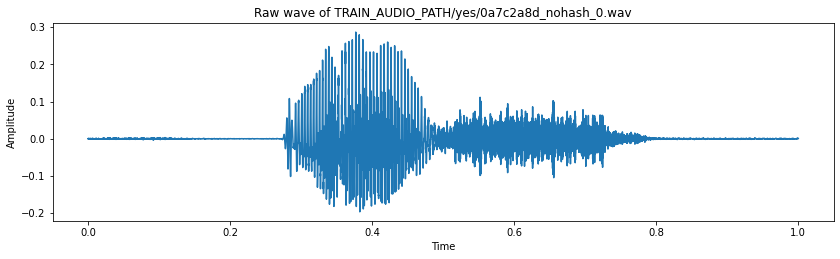

In [3]:
samples, sample_rate = librosa.load(TRAIN_AUDIO_PATH+'yes/0a7c2a8d_nohash_0.wav', sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of TRAIN_AUDIO_PATH/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [5]:
samples_test = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples_test,rate=8000)

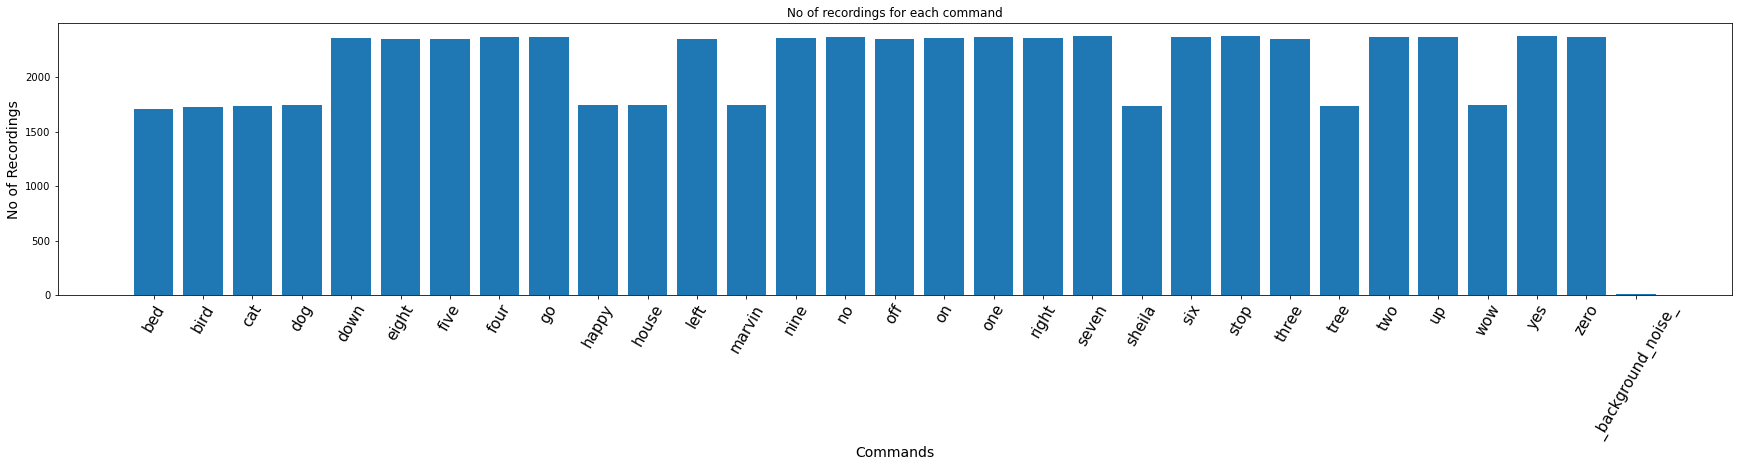

In [6]:
labels = os.listdir(TRAIN_AUDIO_PATH)

no_of_recordings = []
for label in labels:
    waves = [file for file in os.listdir(TRAIN_AUDIO_PATH+'/'+label) if file.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#Plot
plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=14)
plt.ylabel('No of Recordings', fontsize=14)
plt.xticks(index, labels,  fontsize=15, rotation=60)
plt.title('No of recordings for each command')
plt.show()

labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


Wall time: 1min 31s


(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

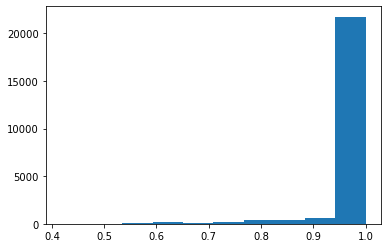

In [7]:
%%time
duration_of_recordings = []
for label in labels:
    waves = [file for file in os.listdir(f"{TRAIN_AUDIO_PATH}/{label}") if file.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(f"{TRAIN_AUDIO_PATH}/{label}/{wav}")
        duration_of_recordings.append(float(len(samples)/sample_rate))
 
plt.hist(np.array(duration_of_recordings))

# Preprocessing the audio waves

In [8]:
%%time
all_wave = []
all_label = []
for label in labels:
    waves = [file for file in os.listdir(f"{TRAIN_AUDIO_PATH}/{label}") if file.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(f"{TRAIN_AUDIO_PATH}/{label}/{wav}", sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) == 8000:
            all_wave.append(samples)
            all_label.append(label)

Wall time: 5min 32s


In [9]:
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [10]:
y = np_utils.to_categorical(y, num_classes = len(labels))
all_wave = np.array(all_wave).reshape(-1,8000,1)

## Splitting the data into training and testing

In [11]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify = y, test_size=0.2, random_state = 777, shuffle=True)

# Building the model

## Imports for the model

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [13]:
K.clear_session()

inputs = Input(shape=(8000, 1))

In [14]:
# First Conv1D Layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [15]:
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [16]:
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [17]:
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [18]:
#Flatten layer
conv = Flatten()(conv)

In [19]:
#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

In [20]:
#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

In [21]:
# Outputs
outputs = Dense(len(labels), activation='softmax')(conv)

In [22]:
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint(filepath="best_model.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
keras_callbacks=[mc, es]

In [25]:
%%time
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=keras_callbacks, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 42s 74ms/step - loss: 2.0240 - accuracy: 0.2380 - val_loss: 1.6356 - val_accuracy: 0.4070
Epoch 2/100
533/533 [==============================] - 41s 78ms/step - loss: 1.4593 - accuracy: 0.4626 - val_loss: 1.2490 - val_accuracy: 0.5728
Epoch 3/100
533/533 [==============================] - 41s 77ms/step - loss: 1.2019 - accuracy: 0.5712 - val_loss: 0.9521 - val_accuracy: 0.6934
Epoch 4/100
533/533 [==============================] - 41s 78ms/step - loss: 0.9945 - accuracy: 0.6539 - val_loss: 0.8585 - val_accuracy: 0.7180
Epoch 5/100
533/533 [==============================] - 38s 72ms/step - loss: 0.8473 - accuracy: 0.7118 - val_loss: 0.7289 - val_accuracy: 0.7558
Epoch 6/100
533/533 [==============================] - 40s 75ms/step - loss: 0.7513 - accuracy: 0.7441 - val_loss: 0.6665 - val_accuracy: 0.7816
Epoch 7/100
533/533 [==============================] - 39s 74ms/step - loss: 0.6838 - accuracy: 0.7646 - val_loss: 0.6424 - val_ac

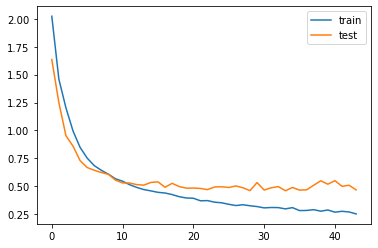

In [26]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

# Saving the Model for prediction

In [ ]:
from keras.models import load_model
model.save('best_model.h5')
model1 = load_model("best_model.h5")

# Making prediction on the validation data

# Recording User's Voice

In [12]:
import sounddevice as sd
import soundfile as sf
import IPython.display as ipd

from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [13]:
saved_model = load_model('best_model.h5');

In [14]:
def predict_audio(audio):
    prob = saved_model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

In [15]:
import random
index = random.randint(0, len(x_val) - 1)
samples = x_val[index].ravel()
print('Audio: ', classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate = 8000)
print("Label: ", predict_audio(samples))

Audio:  on
Label:  on


In [47]:
command_name = input('Enter the command you\'ll be recording: ')

Enter the command you'll be recording: down


In [48]:
sample_rate = 16000
duration = 1
filename = f'voice_commands/{command_name}.wav'
print("Start")
my_voice = sd.rec(int(sample_rate * duration), samplerate=sample_rate,channels=1, blocking= True)
print("End")
sd.wait()
sf.write(filename, my_voice, sample_rate)

Start
End


In [51]:
samples, sample_rate = librosa.load(f'voice_commands/down.wav', sr = 16000)
sample_test = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(sample_test, rate=8000)

In [52]:
predict_audio(sample_test)

'stop'